## Setup

Import necessary modules and dependencies. Note that you'll be using <a href="https://seaborn.pydata.org/" class="external">seaborn</a> for visualization in this tutorial.

In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import keras_utils
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

## Import the mini Speech Commands dataset

To save time with data loading, you will be working with a smaller version of the Speech Commands dataset. The [original dataset](https://www.tensorflow.org/datasets/catalog/speech_commands) consists of over 105,000 audio files in the <a href="https://www.aelius.com/njh/wavemetatools/doc/riffmci.pdf" class="external">WAV (Waveform) audio file format</a> of people saying 35 different words. This data was collected by Google and released under a CC BY license.

Download and extract the `mini_speech_commands.zip` file containing the smaller Speech Commands datasets with `tf.keras.utils.get_file`:

In [2]:
%cd Project\ spectro

[Errno 2] No such file or directory: 'Project spectro'
/home/utente/Scrivania/Uni/HDA/project/Project spectro


In [3]:
DATASET_PATH = 'full_dataset_light/'

data_dir = pathlib.Path(DATASET_PATH)

The dataset's audio clips are stored in `35` folders corresponding to each speech command like `no`, `yes`, `down`, `go`, `left`, `up`, `right`, `stop` and so on

In [4]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
mask = np.logical_and(commands != '.DS_Store', commands !='.ipynb_checkpoints')
commands = commands[mask]
print('Commands:', commands)

Commands: ['cat' 'five' 'bird' 'left' 'follow' 'six' 'bed' 'go' 'learn' 'eight'
 'four' 'happy' 'house' 'off' 'dog' 'stop' 'up' 'wow' 'one' 'on' 'sheila'
 'backward' 'no' 'yes' 'seven' 'forward' 'two' 'nine' 'down' 'tree'
 'right' 'visual' 'three' 'zero' 'marvin']


Extract the audio clips into a list called `filenames`, and shuffle it:

In [5]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/commands[0]))))

Number of total examples: 26250
Number of examples per label: 750


2022-05-22 17:03:37.125398: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-22 17:03:37.137794: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-22 17:03:37.138185: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-22 17:03:37.138900: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Split `filenames` into training, validation and test sets using a 70:20:10 ratio, respectively:

In [6]:
train_files = filenames[:int(num_samples*0.7)]
val_files = filenames[int(num_samples*0.7):int(num_samples*0.7)+int(num_samples*0.2)]
test_files = filenames[-int(num_samples*0.1):]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 18375
Validation set size 5250
Test set size 2625


## Read the audio files and their labels

In this section you will preprocess the dataset, creating decoded tensors for the waveforms and the corresponding labels. Note that:

- Each WAV file contains time-series data with a set number of samples per second.
- Each sample represents the <a href="https://en.wikipedia.org/wiki/Amplitude" class="external">amplitude</a> of the audio signal at that specific time.
- In a <a href="https://en.wikipedia.org/wiki/Audio_bit_depth" class="external">16-bit</a> system, like the WAV files in the mini Speech Commands dataset, the amplitude values range from -32,768 to 32,767.
- The <a href="https://en.wikipedia.org/wiki/Sampling_(signal_processing)#Audio_sampling" class="external">sample rate</a> for this dataset is 16kHz.

The shape of the tensor returned by `tf.audio.decode_wav` is `[samples, channels]`, where `channels` is `1` for mono or `2` for stereo. The mini Speech Commands dataset only contains mono recordings. 

Now, let's define a function that preprocesses the dataset's raw WAV audio files into audio tensors:

In [7]:
def decode_audio(audio_binary):
    # Decode WAV-encoded audio files to `float32` tensors, normalized
    # to the [-1.0, 1.0] range. Return `float32` audio and a sample rate.
    audio, _ = tf.audio.decode_wav(contents=audio_binary)
    # Since all the data is single channel (mono), drop the `channels`
    # axis from the array.
    return tf.squeeze(audio, axis=-1)

Define a function that creates labels using the parent directories for each file:

- Split the file paths into `tf.RaggedTensor`s (tensors with ragged dimensions—with slices that may have different lengths).

In [8]:
def get_label(file_path):
    parts = tf.strings.split(
      input=file_path,
      sep=os.path.sep)
  # Note: You'll use indexing here instead of tuple unpacking to enable this
  # to work in a TensorFlow graph.
    return parts[-2]


Define another helper function—`get_waveform_and_label`—that puts it all together:

- The input is the WAV audio filename.
- The output is a tuple containing the audio and label tensors ready for supervised learning.

In [9]:
def get_waveform_and_label(file_path):
    label = get_label(file_path)
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)
    return waveform, label

Build the training set to extract the audio-label pairs:

- Create a `tf.data.Dataset` with `Dataset.from_tensor_slices` and `Dataset.map`, using `get_waveform_and_label` defined earlier.

You'll build the validation and test sets using a similar procedure later on.

In [10]:
AUTOTUNE = tf.data.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)

waveform_ds = files_ds.map(
    map_func=get_waveform_and_label,
    num_parallel_calls=AUTOTUNE)

Let's plot a few audio waveforms:

2022-05-22 17:03:38.357269: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


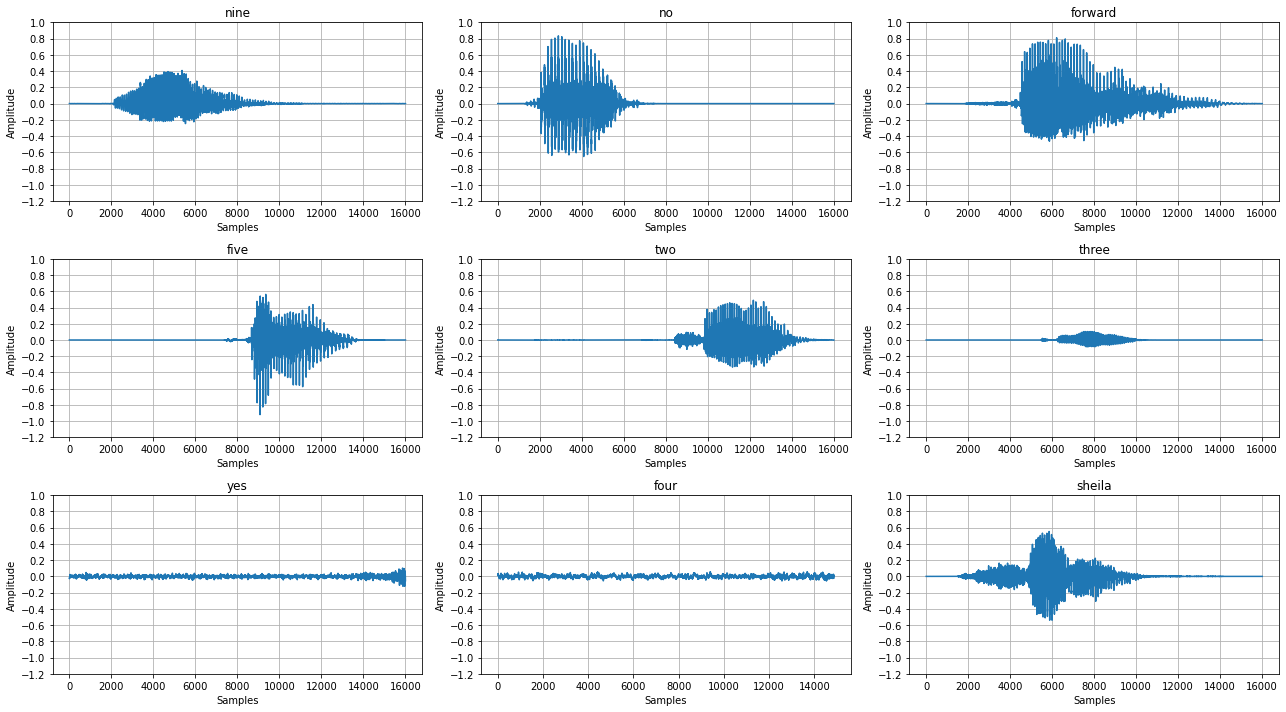

In [11]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(18, 10))

for i, (audio, label) in enumerate(waveform_ds.take(n)):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    ax.plot(audio.numpy())
    ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
    label = label.numpy().decode('utf-8')
    ax.set_ylabel("Amplitude")
    ax.set_xlabel("Samples")
    ax.set_title(label)
    ax.grid()
fig.tight_layout()
plt.show()

## Convert waveforms to spectrograms

The waveforms in the dataset are represented in the time domain. Next, you'll transform the waveforms from the time-domain signals into the time-frequency-domain signals by computing the <a href="https://en.wikipedia.org/wiki/Short-time_Fourier_transform" class="external">short-time Fourier transform (STFT)</a> to convert the waveforms to as <a href="https://en.wikipedia.org/wiki/Spectrogram" clas="external">spectrograms</a>, which show frequency changes over time and can be represented as 2D images. You will feed the spectrogram images into your neural network to train the model.

A Fourier transform (`tf.signal.fft`) converts a signal to its component frequencies, but loses all time information. In comparison, STFT (`tf.signal.stft`) splits the signal into windows of time and runs a Fourier transform on each window, preserving some time information, and returning a 2D tensor that you can run standard convolutions on.

Create a utility function for converting waveforms to spectrograms:

- The waveforms need to be of the same length, so that when you convert them to spectrograms, the results have similar dimensions. This can be done by simply zero-padding the audio clips that are shorter than one second (using `tf.zeros`).
- When calling `tf.signal.stft`, choose the `frame_length` and `frame_step` parameters such that the generated spectrogram "image" is almost square. For more information on the STFT parameters choice, refer to <a href="https://www.coursera.org/lecture/audio-signal-processing/stft-2-tjEQe" class="external">this Coursera video</a> on audio signal processing and STFT.
- The STFT produces an array of complex numbers representing magnitude and phase. However, in this tutorial you'll only use the magnitude, which you can derive by applying `tf.abs` on the output of `tf.signal.stft`.

In [12]:
def get_spectrogram(waveform):
    # Zero-padding for an audio waveform with less than 16,000 samples.
    input_len = 16000
    waveform = waveform[:input_len]
    zero_padding = tf.zeros(
        [16000] - tf.shape(waveform),
        dtype=tf.float32)
    # Cast the waveform tensors' dtype to float32.
    waveform = tf.cast(waveform, dtype=tf.float32)
    # Concatenate the waveform with `zero_padding`, which ensures all audio
    # clips are of the same length.
    equal_length = tf.concat([waveform, zero_padding], 0)
    # Convert the waveform to a spectrogram via a STFT.
    spectrogram = tf.signal.stft(
        equal_length, frame_length=255, frame_step=128)
    # Obtain the magnitude of the STFT.
    spectrogram = tf.abs(spectrogram)
    #spectrogram=spectrogram/tf.reduce_max(spectrogram).numpy()

    # Add a `channels` dimension, so that the spectrogram can be used
    # as image-like input data with convolution layers (which expect
    # shape (`batch_size`, `height`, `width`, `channels`).
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram

Next, start exploring the data. Print the shapes of one example's tensorized waveform and the corresponding spectrogram, and play the original audio:

In [13]:
for waveform, label in waveform_ds.take(2):
    label = label.numpy().decode('utf-8')
    spectrogram = get_spectrogram(waveform)

    print('Label:', label)
    print('Waveform shape:', waveform.shape)
    print('Spectrogram shape:', spectrogram.shape)
    print('Audio playback')
    display.display(display.Audio(waveform, rate=16000))

Label: nine
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: no
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Now, define a function for displaying a spectrogram:

In [14]:
def plot_spectrogram(spectrogram, ax):
    if len(spectrogram.shape) > 2:
      assert len(spectrogram.shape) == 3
      spectrogram = np.squeeze(spectrogram, axis=-1)
    # Convert the frequencies to log scale and transpose, so that the time is
    # represented on the x-axis (columns).
    # Add an epsilon to avoid taking a log of zero.
    log_spec = np.log(spectrogram.T + np.finfo(float).eps)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)

Plot the example's waveform over time and the corresponding spectrogram (frequencies over time):

/tmp/ipykernel_4948/535791129.py:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(X, Y, log_spec)


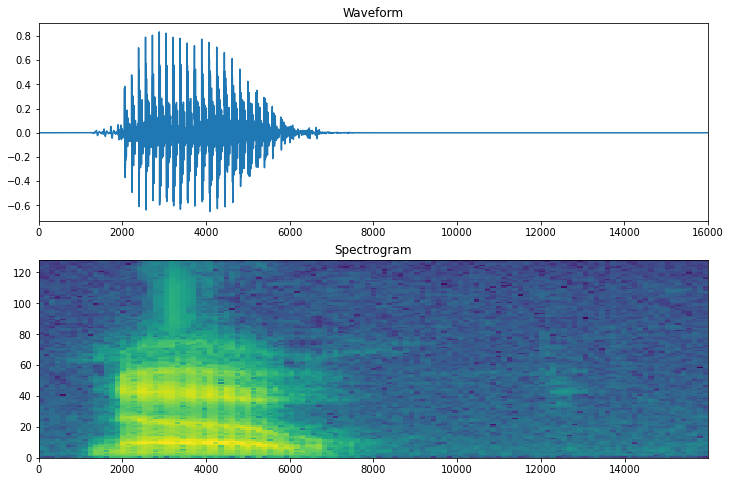

In [15]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

Now, define a function that transforms the waveform dataset into spectrograms and their corresponding labels as integer IDs:

In [16]:

def get_spectrogram_and_label_id(audio, label):

    spectrogram = get_spectrogram(audio)
    indice = tf.argmax(label == commands)
    #label_id = tf.one_hot(indice, len(commands))
    label_id=indice
    return spectrogram, label_id

Map `get_spectrogram_and_label_id` across the dataset's elements with `Dataset.map`:

In [17]:
spectrogram_ds = waveform_ds.map(
  map_func=get_spectrogram_and_label_id,
  num_parallel_calls=AUTOTUNE)

Examine the spectrograms for different examples of the dataset:

## Build and train the model

Repeat the training set preprocessing on the validation and test sets:

In [18]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(
      map_func=get_waveform_and_label,
      num_parallel_calls=AUTOTUNE)
    
  output_ds = output_ds.map(
      map_func=get_spectrogram_and_label_id,
num_parallel_calls=AUTOTUNE)
  return output_ds

In [19]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

For the model, you'll use a simple convolutional neural network (CNN), since you have transformed the audio files into spectrogram images.

Your `tf.keras.Sequential` model will use the following Keras preprocessing layers:

- `tf.keras.layers.Resizing`: to downsample the input to enable the model to train faster.
- `tf.keras.layers.Normalization`: to normalize each pixel in the image based on its mean and standard deviation.

For the `Normalization` layer, its `adapt` method would first need to be called on the training data in order to compute aggregate statistics (that is, the mean and the standard deviation).

In [20]:
train_x = train_ds.map(lambda x,y: x,num_parallel_calls=AUTOTUNE) 
train_y = train_ds.map(lambda x,y: y,num_parallel_calls=AUTOTUNE)

val_x = val_ds.map(lambda x,y: x,num_parallel_calls=AUTOTUNE) 
#val_y = val_ds.map(lambda x,y: y,num_parallel_calls=AUTOTUNE)

test_x = test_ds.map(lambda x,y: x,num_parallel_calls=AUTOTUNE) 
#test_y = test_ds.map(lambda x,y: y,num_parallel_calls=AUTOTUNE)

In [21]:
train_x = train_x.map(lambda image,: tf.image.resize(image, [100, 100]))
val_x = val_x.map(lambda image: tf.image.resize(image, [100, 100]))
test_x = test_x.map(lambda image: tf.image.resize(image, [100, 100]))

train_x = train_x.map(lambda x: (x/tf.reduce_max(x)),num_parallel_calls=AUTOTUNE) 
val_x = val_x.map(lambda x: (x/tf.reduce_max(x)),num_parallel_calls=AUTOTUNE) 
test_x = test_x.map(lambda x: (x/tf.reduce_max(x)),num_parallel_calls=AUTOTUNE) 


In [22]:
for i in train_x.take(50):
    print("max:",i.numpy().max(),"    min:", i.numpy().min())

max: 1.0     min: 5.0178946e-06
max: 1.0     min: 1.1002516e-06
max: 1.0     min: 2.41101e-06
max: 1.0     min: 0.0
max: 1.0     min: 3.5872781e-06
max: 1.0     min: 4.015685e-06
max: 1.0     min: 8.273384e-05
max: 1.0     min: 0.0
max: 1.0     min: 1.3568783e-06
max: 1.0     min: 8.778862e-07
max: 1.0     min: 5.9899944e-06
max: 1.0     min: 1.005308e-05
max: 1.0     min: 2.3724278e-06
max: 1.0     min: 0.0
max: 1.0     min: 1.7832409e-06
max: 1.0     min: 1.1533989e-06
max: 1.0     min: 9.089889e-07
max: 1.0     min: 7.910148e-06
max: 1.0     min: 3.666294e-05
max: 1.0     min: 1.3927923e-06
max: 1.0     min: 0.0
max: 1.0     min: 0.0
max: 1.0     min: 1.8795613e-06
max: 1.0     min: 6.4580905e-07
max: 1.0     min: 1.0456815e-06
max: 1.0     min: 6.1089404e-06
max: 1.0     min: 0.0
max: 1.0     min: 6.438818e-07
max: 1.0     min: 9.654021e-07
max: 1.0     min: 7.528887e-07
max: 1.0     min: 1.1113811e-05
max: 1.0     min: 3.7870195e-06
max: 1.0     min: 9.2333875e-07
max: 1.0     min

In [23]:
train_x = train_x.map(lambda x: (x,x),num_parallel_calls=AUTOTUNE) 
val_x = val_x.map(lambda x: (x,x),num_parallel_calls=AUTOTUNE) 
test_x = test_x.map(lambda x: (x,x),num_parallel_calls=AUTOTUNE) 


In [24]:
batch_size = 32

train_steps = int(np.ceil(len(train_x) / batch_size))
val_steps = int(np.ceil(len(val_x) / batch_size))
test_steps = int(np.ceil(len(test_x) / batch_size))

In [25]:
train_x = train_x.batch(batch_size)
val_x = val_x.batch(batch_size)
test_x = test_x.batch(batch_size)


train_x = train_x.cache().prefetch(AUTOTUNE)
val_x = val_x.cache().prefetch(AUTOTUNE)
test_x = test_x.cache().prefetch(AUTOTUNE)

In [26]:
for spectrogram,_ in train_x.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)

Input shape: (32, 100, 100, 1)


2022-05-22 17:03:44.374263: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [27]:
img_shape=(100, 100, 1)

In [29]:
def build_deep_autoencoder(img_shape, code_size):
    """
    Arguments:
    img_shape_x -- size of the input layer
    code_size -- the size of the hidden representation of the input (code)

    Returns:
    encoder -- keras model for the encoder network
    decoder -- keras model for the decoder network
    """

    # encoder
    encoder = tf.keras.Sequential()
    encoder.add(tf.keras.Input(img_shape))
    encoder.add(layers.Conv2D(32, 2, activation='relu', padding='same'))
    encoder.add(layers.MaxPooling2D(pool_size=2))

    encoder.add(layers.Conv2D(32, 2, activation='relu', padding='same'))
    encoder.add(layers.MaxPooling2D(pool_size=2))

    encoder.add(layers.Conv2D(32, 2, activation='relu', padding='same'))
    encoder.add(layers.MaxPooling2D(pool_size=2))

    encoder.add(layers.Conv2D(64, 2, activation='relu', padding='same'))
    encoder.add(layers.MaxPooling2D(pool_size=2))

    encoder.add(layers.Flatten())
    encoder.add(layers.Dense(code_size))

    # decoder
    decoder = tf.keras.Sequential()
    decoder.add(tf.keras.Input((code_size,)))

    decoder.add(layers.Dense(6 * 6 * 64, activation='relu'))
    decoder.add(layers.Reshape((6, 6, 64)))
    decoder.add(layers.Conv2DTranspose(128, (3, 3), strides=2, activation='relu', padding='same'))
    decoder.add(layers.Conv2DTranspose(32, (3, 3), strides=2, activation='relu', padding='valid'))
    decoder.add(layers.Conv2DTranspose(32, (3, 3), strides=2, activation='relu', padding='same'))
    decoder.add(layers.Conv2DTranspose(1, (3, 3), strides=2, activation=None, padding='same'))

    return encoder, decoder

In [29]:
# check autoencoder shapes along different code_sizes
get_dim = lambda layer: np.prod(layer.output_shape[1:])
for code_size in [1, 8, 32, 128, 512]:
    encoder, decoder = build_deep_autoencoder(img_shape, code_size=code_size)
    print("Testing code size %i" % code_size)
    assert encoder.output_shape[1:] == (code_size,), "encoder must output a code of required size"
    assert decoder.output_shape[1:] == img_shape, "decoder must output an image of valid shape"
    assert len(encoder.trainable_weights) >= 6, "encoder must contain at least 3 layers"
    assert len(decoder.trainable_weights) >= 6, "decoder must contain at least 3 layers"

    for layer in encoder.layers + decoder.layers:
        assert get_dim(layer) >= code_size, "Encoder layer %s is smaller than bottleneck (%i units)" % (
        layer.name, get_dim(layer))

print("All tests passed!")

Testing code size 1
Testing code size 8
Testing code size 32
Testing code size 128
Testing code size 512
All tests passed!


In [30]:
encoder, decoder = build_deep_autoencoder(img_shape, code_size=210)
encoder.summary()
decoder.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 100, 100, 32)      160       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 50, 50, 32)        4128      
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 25, 25, 32)        4128      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 12, 12, 64)      

In [31]:
# call the above function to create the encoder and decoder models, use code_size=32

encoder, decoder = build_deep_autoencoder(img_shape, code_size=210)

In [32]:
# build the deep autoencoder network

# 1- instatiate the input tensor (hint: use tf.keras.Input(IMG_SHAPE))
# 2- get the code (output of the encoder)
# 3 -pass the code to the decoder and get the recunstruction
inp = tf.keras.Input(img_shape)
code = encoder(inp)
reconstruction = decoder(code)

# create the autoencoder model: use tf.keras.Model() with the correct input and output tensors from the line above
autoencoder = tf.keras.Model(inputs=inp, outputs=reconstruction)

In [33]:
# with the next lines, you save model's checkpoints to continue training in case of kernel death
#model_filename = 'autoencoder_network.hdf5'
#last_finished_epoch = None

#### uncomment below to continue training from model checkpoint
# last_finished_epoch = 4  # replace with your latest finished epoch
# autoencoder = load_model(model_filename)
# encoder = autoencoder.layers[1]
# decoder = autoencoder.layers[2]

In [34]:
autoencoder.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=['accuracy'],
)

In [35]:
history = autoencoder.fit(train_x,epochs=50,
                          steps_per_epoch=train_steps,
                          validation_data=val_x,
                          validation_steps=val_steps,
                          verbose=1)

Epoch 1/50


2022-05-22 16:42:02.726606: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8302
2022-05-22 16:42:03.556166: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-05-22 16:42:03.557320: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-05-22 16:42:03.557351: W tensorflow/stream_executor/gpu/asm_compiler.cc:77] Couldn't get ptxas version string: Internal: Couldn't invoke ptxas --version
2022-05-22 16:42:03.558006: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-05-22 16:42:03.558122: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


575/575 [==============================] - 28s 44ms/step - loss: 0.0015 - accuracy: 0.0241 - val_loss: 8.9161e-04 - val_accuracy: 0.0241
Epoch 2/50
575/575 [==============================] - 24s 41ms/step - loss: 8.0135e-04 - accuracy: 0.0241 - val_loss: 7.1814e-04 - val_accuracy: 0.0242
Epoch 3/50
575/575 [==============================] - 24s 41ms/step - loss: 6.8359e-04 - accuracy: 0.0242 - val_loss: 6.4962e-04 - val_accuracy: 0.0242
Epoch 4/50
575/575 [==============================] - 23s 41ms/step - loss: 6.2058e-04 - accuracy: 0.0242 - val_loss: 6.2394e-04 - val_accuracy: 0.0242
Epoch 5/50
575/575 [==============================] - 23s 41ms/step - loss: 5.7857e-04 - accuracy: 0.0242 - val_loss: 5.9878e-04 - val_accuracy: 0.0242
Epoch 6/50
575/575 [==============================] - 23s 41ms/step - loss: 5.4837e-04 - accuracy: 0.0242 - val_loss: 5.7673e-04 - val_accuracy: 0.0242
Epoch 7/50
575/575 [==============================] - 24s 41ms/step - loss: 5.2484e-04 - accuracy: 0.02

In [37]:
# save trained weights
encoder.save_weights("encoder.h5")
decoder.save_weights("decoder.h5")

## SVM

In [48]:
%pwd

'/home/utente/Scrivania/Uni/HDA/project/Project spectro'

In [30]:
# restore trained encoder weights
encoder, _ = build_deep_autoencoder(img_shape, code_size=210)
encoder.load_weights("encoder.h5")

note: codes will be a numpy array

In [31]:
# encode the images in the training set  
train_codes = encoder.predict(train_x, steps=train_steps)


2022-05-22 17:04:05.940667: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8302
2022-05-22 17:04:06.335107: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-05-22 17:04:06.336524: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-05-22 17:04:06.336572: W tensorflow/stream_executor/gpu/asm_compiler.cc:77] Couldn't get ptxas version string: Internal: Couldn't invoke ptxas --version
2022-05-22 17:04:06.337171: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-05-22 17:04:06.337279: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


In [32]:
# encode the images in the training set  
test_codes = encoder.predict(test_x, steps=test_steps)



## To create the array with labels:

In [33]:
test_y = test_ds.map(lambda x,y: y,num_parallel_calls=AUTOTUNE)
train_y = train_ds.map(lambda x,y: y,num_parallel_calls=AUTOTUNE)


In [34]:
y_test = np.stack([row for row in test_y])
y_train = np.stack([row for row in train_y])

In [35]:
print("train info:")
print("label shapes",y_train.shape)
print("samples shapes",train_codes.shape,"\n")
print("test info:")
print("label shapes",y_test.shape)
print("samples shapes",test_codes.shape)

train info:
label shapes (18375,)
samples shapes (18375, 210) 

test info:
label shapes (2625,)
samples shapes (2625, 210)


In [37]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

In [38]:
params_grid = [{'kernel': ['rbf'], 'gamma': [1e-2,1e-3, 1e-4,1e-5],
                     'C': [ 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [ 10, 100]},
              {"kernel":["poly"], "degree":[3], 'gamma': [1e-2,1e-3, 1e-4,1e-5],'C': [ 10, 100]}]


In [39]:

#Libraries to Build Ensemble Model : Random Forest Classifier 
# Create the parameter grid based on the results of random search 
#params_grid = [{'kernel': ['rbf'], 'gamma': [1e-2,1e-3, 1e-4,1e-5],
#                     'C': [ 10, 100, 1000]},
#                    {'kernel': ['linear'], 'C': [ 10, 100]},
#              {"kernel":["poly"], "degree":[3,5,8], 'gamma': [1e-2,1e-3, 1e-4,1e-5],'C': [ 10, 100]}]
#

In [40]:
# Performing CV to tune parameters for best SVM fit 
svm_model = GridSearchCV(SVC(), params_grid,n_jobs=-1,verbose=2)
svm_model.fit(train_codes, y_train)

Fitting 5 folds for each of 22 candidates, totalling 110 fits


GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid=[{'C': [10, 100, 1000],
                          'gamma': [0.01, 0.001, 0.0001, 1e-05],
                          'kernel': ['rbf']},
                         {'C': [10, 100], 'kernel': ['linear']},
                         {'C': [10, 100], 'degree': [3],
                          'gamma': [0.01, 0.001, 0.0001, 1e-05],
                          'kernel': ['poly']}],
             verbose=2)

In [41]:
# View the accuracy score
print('Best score for training data:', svm_model.best_score_,"\n") 

# View the best parameters for the model found using grid search
print('Best C:',svm_model.best_estimator_.C,"\n") 
print('Best Kernel:',svm_model.best_estimator_.kernel,"\n")
print('Best Gamma:',svm_model.best_estimator_.gamma,"\n")

final_model = svm_model.best_estimator_
y_pred = final_model.predict(test_codes)


Best score for training data: 0.6706938775510204 

Best C: 10 

Best Kernel: rbf 

Best Gamma: 0.01 



In [42]:
from sklearn.metrics import confusion_matrix,classification_report


In [43]:

print("\n")
print("\n")
print(classification_report(y_test,y_pred))





              precision    recall  f1-score   support

           0       0.59      0.72      0.65        79
           1       0.64      0.62      0.63        87
           2       0.71      0.77      0.74        78
           3       0.49      0.60      0.54        77
           4       0.68      0.67      0.67        82
           5       0.76      0.82      0.79        83
           6       0.63      0.65      0.64        95
           7       0.53      0.63      0.57        75
           8       0.75      0.70      0.72        66
           9       0.73      0.81      0.77        68
          10       0.64      0.68      0.66        76
          11       0.69      0.73      0.71        59
          12       0.82      0.80      0.81        76
          13       0.62      0.65      0.63        62
          14       0.62      0.66      0.64        65
          15       0.75      0.84      0.79        70
          16       0.73      0.74      0.73        93
          17       0.77

In [ ]:
           precision    recall  f1-score   support

           0       0.59      0.72      0.65        79
           1       0.64      0.62      0.63        87
           2       0.71      0.77      0.74        78
           3       0.49      0.60      0.54        77
           4       0.68      0.67      0.67        82
           5       0.76      0.82      0.79        83
           6       0.63      0.65      0.64        95
           7       0.53      0.63      0.57        75
           8       0.75      0.70      0.72        66
           9       0.73      0.81      0.77        68
          10       0.64      0.68      0.66        76
          11       0.69      0.73      0.71        59
          12       0.82      0.80      0.81        76
          13       0.62      0.65      0.63        62
          14       0.62      0.66      0.64        65
          15       0.75      0.84      0.79        70
          16       0.73      0.74      0.73        93
          17       0.77      0.66      0.71        77
          18       0.74      0.68      0.71        96
          19       0.64      0.59      0.61        71
          20       0.89      0.78      0.83        73
          21       0.85      0.80      0.82        88
          22       0.73      0.64      0.68        86
          23       0.83      0.78      0.80        55
          24       0.73      0.70      0.72        70
          25       0.60      0.62      0.61        66
          26       0.62      0.83      0.71        63
          27       0.67      0.71      0.69        58
          28       0.80      0.63      0.71        82
          29       0.76      0.67      0.71        72
          30       0.79      0.60      0.69        81
          31       0.84      0.78      0.81        74
          32       0.64      0.61      0.62        76
          33       0.75      0.77      0.76        66
          34       0.81      0.75      0.78        80

    accuracy                           0.70      2625
   macro avg       0.71      0.71      0.71      2625
weighted avg       0.71      0.70      0.70      2625

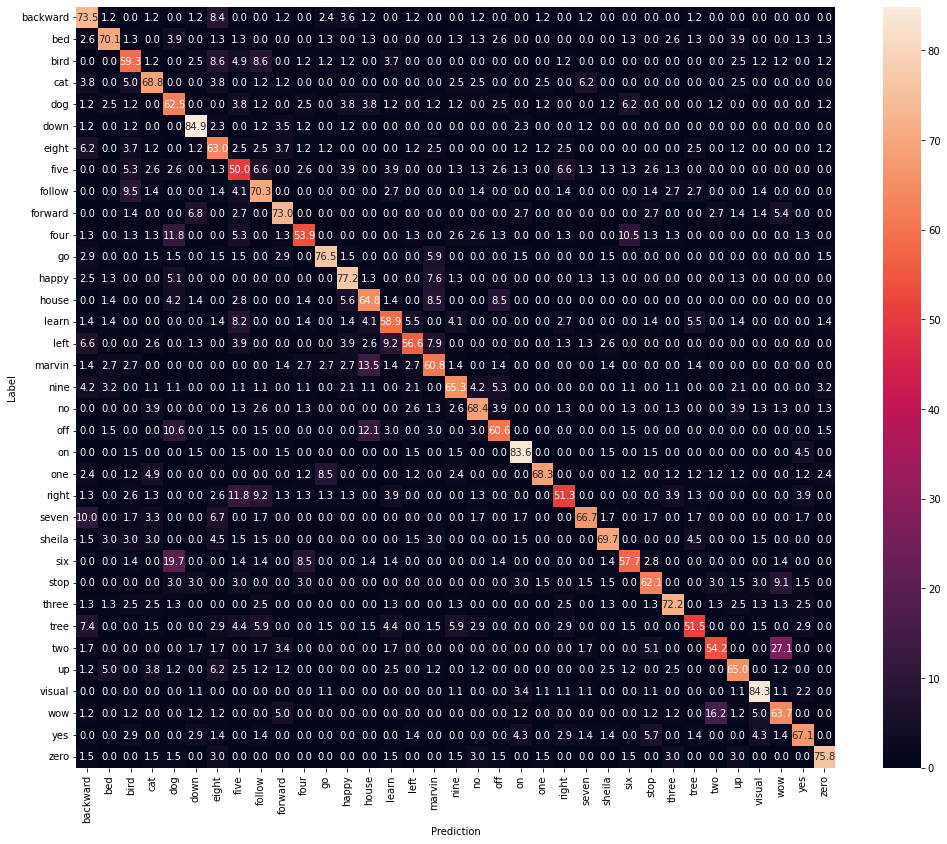

[CV] END .......................C=10, gamma=0.01, kernel=rbf; total time= 2.2min
[CV] END .....................C=10, gamma=0.0001, kernel=rbf; total time= 4.3min
[CV] END ......................C=100, gamma=0.01, kernel=rbf; total time= 2.1min
[CV] END ......................C=100, gamma=0.01, kernel=rbf; total time= 2.0min
[CV] END ....................C=100, gamma=0.0001, kernel=rbf; total time= 2.8min
[CV] END .....................C=100, gamma=1e-05, kernel=rbf; total time= 3.9min
[CV] END ....................C=1000, gamma=0.001, kernel=rbf; total time= 2.0min
[CV] END ....................C=1000, gamma=1e-05, kernel=rbf; total time= 2.4min
[CV] END ...............................C=100, kernel=linear; total time= 4.2min
[CV] END ...........C=10, degree=3, gamma=0.001, kernel=poly; total time= 5.0min
[CV] END ...........C=10, degree=3, gamma=1e-05, kernel=poly; total time= 5.1min
[CV] END ............C=10, degree=5, gamma=0.01, kernel=poly; total time= 5.1min
[CV] END ..........C=10, deg

In [43]:
from sklearn.metrics import confusion_matrix
commands = ['backward','bed','bird','cat','dog','down','eight','five','follow',
 'forward','four','go','happy','house','learn','left','marvin',
 'nine', 'no', 'off', 'on', 'one', 'right', 'seven','sheila','six','stop',
 'three', 'tree', 'two', 'up', 'visual','wow','yes','zero']

confusion_matrix=confusion_matrix(y_test, y_pred)
confusion_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]*100
plt.figure(figsize=(17, 14))

sns.heatmap(confusion_matrix,
            xticklabels=commands,
            yticklabels=commands,
            annot=True, fmt='.1f')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.savefig('conf.png')
plt.show()